In [5]:
from pathlib import Path
import pandas as pd
from anthropic import Anthropic
import time
from datetime import datetime
import os
from dotenv import load_dotenv
from typing import List, Dict

# Load environment variables
load_dotenv()

# Get API key from environment
ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_API_KEY')
if not ANTHROPIC_API_KEY:
    raise ValueError("ANTHROPIC_API_KEY not found in environment variables")

client = Anthropic(api_key=ANTHROPIC_API_KEY)

def generate_detailed_objectives_for_subskill(subskill_data):
    """Generate detailed learning objectives for a specific subskill"""
    
    # Print debug info
    subskill_desc = subskill_data['SubskillDescription'].iloc[0]
    print(f"\n📝 Processing subskill: {subskill_desc}")
    
    # Create detailed context string from subskill data
    row = subskill_data.iloc[0]
    context = (f"Subject: {row['Subject']}\n"
              f"Unit: {row['UnitTitle']} ({row['UnitID']})\n"
              f"Skill: {row['SkillDescription']} ({row['SkillID']})\n"
              f"Subskill: {row['SubskillDescription']} ({row['SubskillID']})\n")

    prompt = f"""Please analyze this specific kindergarten curriculum subskill and generate 5-8 detailed learning objectives. Each objective should be on a new line, following the exact CSV format specified below.

{context}

The output must be EXACTLY in this CSV format (one objective per line):
{row['Subject']},{row['SubskillID']},{row['SubskillDescription']},<ConceptGroup>,<DetailedObjective>

For example:
Mathematics,{row['SubskillID']},{row['SubskillDescription']},Number Recognition,Match spoken numbers with written numerals
Mathematics,{row['SubskillID']},{row['SubskillDescription']},Counting Skills,Count objects sequentially from 1 to 10

Requirements for objectives:
1. Must be specific, measurable, and appropriate for kindergarten (age 5-6)
2. Show progression from basic to more advanced understanding
3. Include various contexts and real-world applications
4. Focus on this specific subskill's scope
5. Each line must follow the exact CSV format shown above

Generate at least 5 varied objectives that cover different aspects of learning this skill."""

    try:
        print("  • Sending request to Claude API...")
        response = client.messages.create(
            model="claude-3-5-haiku-20241022",
            max_tokens=2048,
            temperature=0.7,
            messages=[{"role": "user", "content": prompt}]
        )
        print("  • Received response from Claude")
        
        # Print raw response for debugging
        print("\nRaw response from Claude:")
        print(response.content[0].text.strip())
        print("\nProcessing response lines...")
        
        # Parse and validate each line
        objectives = []
        for line in response.content[0].text.strip().split('\n'):
            if not line:
                continue
                
            try:
                # Split only on first two commas to get subject and subskill_id
                parts = line.split(',', 2)
                if len(parts) < 3:
                    print(f"  • Skipping line with insufficient parts: {line}")
                    continue
                
                subject, subskill_id, remainder = parts
                
                # Find the last two commas in the remainder to extract concept_group and objective
                last_comma_pos = remainder.rindex(',')
                second_last_comma_pos = remainder.rindex(',', 0, last_comma_pos)
                
                subskill_desc = remainder[:second_last_comma_pos]
                concept_group = remainder[second_last_comma_pos + 1:last_comma_pos].strip()
                objective = remainder[last_comma_pos + 1:].strip()
                
                # Validate all parts exist
                if not all([subject, subskill_id, subskill_desc, concept_group, objective]):
                    print("  • Skipping line with empty fields")
                    continue
                
                # Validate that SubskillID matches our input
                if subskill_id.strip() == row['SubskillID']:
                    objectives.append({
                        'Subject': subject.strip(),
                        'SubskillID': subskill_id.strip(),
                        'SubskillDescription': subskill_desc.strip(),
                        'ConceptGroup': concept_group,
                        'DetailedObjective': objective
                    })
                    print(f"  • Added objective: {concept_group} - {objective}")
                
            except ValueError as e:
                print(f"  • Error parsing line: {str(e)}")
                continue
        
        print(f"  • Successfully generated {len(objectives)} objectives")
        return objectives
        
    except Exception as e:
        print(f"❌ Error generating objectives for {row['SubskillID']}: {str(e)}")
        print(f"Exception details: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        return []

def process_curriculum_from_csv(input_csv: str, output_csv: str, subject: str = None):
    """Process curriculum from CSV file and generate detailed objectives"""
    
    start_time = time.time()
    print(f"\n🔄 Starting processing at {datetime.now().strftime('%H:%M:%S')}")
    
    # Read CSV file
    print(f"  • Reading input CSV: {input_csv}")
    df = pd.read_csv(input_csv)
    
    # Filter by subject if specified
    if subject:
        df = df[df['Subject'] == subject]
        print(f"  • Filtered to {len(df)} rows for subject: {subject}")
    else:
        print(f"  • Processing all {len(df)} rows")
    
    all_objectives = []
    
    # Process each unique subskill
    unique_subskills = df['SubskillID'].unique()
    print(f"  • Found {len(unique_subskills)} unique subskills to process")
    
    try:
        for idx, subskill_id in enumerate(unique_subskills, 1):
            print(f"\n✨ Processing subskill {idx}/{len(unique_subskills)}")
            subskill_df = df[df['SubskillID'] == subskill_id]
            
            objectives = generate_detailed_objectives_for_subskill(subskill_df)
            if objectives:
                all_objectives.extend(objectives)
                
                # Save progress after each subskill
                temp_df = pd.DataFrame(all_objectives)
                temp_df.to_csv(f"{output_csv}.temp", index=False)
                print(f"  • Saved progress ({len(all_objectives)} total objectives so far)")
            else:
                print(f"⚠️ WARNING: No valid objectives generated for {subskill_id}")
            
            # Add a small delay between API calls
            print("  • Waiting 2 seconds before next API call...")
            time.sleep(2)
    except KeyboardInterrupt:
        print("\n⚠️ Processing interrupted by user")
    except Exception as e:
        print(f"\n❌ Error during processing: {str(e)}")
        import traceback
        traceback.print_exc()
    finally:
        # Save whatever we have so far
        if all_objectives:
            print("\n💾 Saving final results...")
            objectives_df = pd.DataFrame(all_objectives)
            objectives_df.to_csv(output_csv, index=False)
            print(f"✅ Saved {len(objectives_df)} total objectives to {output_csv}")
            
            # Remove temp file if it exists
            temp_file = Path(f"{output_csv}.temp")
            if temp_file.exists():
                temp_file.unlink()
        else:
            print("\n❌ WARNING: No objectives were generated!")
        
        elapsed_time = time.time() - start_time
        print(f"\n🏁 Processing completed in {elapsed_time:.1f} seconds")
        
        return objectives_df if all_objectives else None

input_csv = "data/science_refactored-syllabus.csv"
output_csv = "data/detailed_objectives_science.csv"
    
# Process all subjects
df = process_curriculum_from_csv(input_csv, output_csv)



🔄 Starting processing at 11:57:14
  • Reading input CSV: data/science_refactored-syllabus.csv
  • Processing all 88 rows
  • Found 88 unique subskills to process

✨ Processing subskill 1/88

📝 Processing subskill: Identify and demonstrate basic movements (push, pull, roll, slide) of everyday objects
  • Sending request to Claude API...
  • Received response from Claude

Raw response from Claude:
Science,SCI001-01-A,Identify and demonstrate basic movements (push, pull, roll, slide) of everyday objects,Movement Identification,Verbally name and point to at least 3 different types of object movements (push, pull, roll, slide)
Science,SCI001-01-A,Identify and demonstrate basic movements (push, pull, roll, slide) of everyday objects,Physical Demonstration,Physically demonstrate a push or pull motion with classroom toys and manipulatives
Science,SCI001-01-A,Identify and demonstrate basic movements (push, pull, roll, slide) of everyday objects,Surface Interaction,Predict and explain how diffe

In [24]:
#develop pairwise comparison across all skills to find similarity, dependency, reinforcement
from pathlib import Path
import pandas as pd
from anthropic import Anthropic
import time
from datetime import datetime
import os
from dotenv import load_dotenv
import json
from typing import List, Dict

class SyllabusGraphBuilder:
    def __init__(self):
        # Load environment variables
        load_dotenv()
        
        # Initialize Anthropic client
        self.api_key = os.getenv('ANTHROPIC_API_KEY')
        if not self.api_key:
            raise ValueError("ANTHROPIC_API_KEY not found in environment variables")
        self.client = Anthropic(api_key=self.api_key)
        
        # Storage for results
        self.comparison_cache = {}
        self.relationship_graph = {}

    def compare_skills(self, skill1: Dict, skill2: Dict) -> Dict:
        """Compare a single pair of skills using Claude"""
        # Create cache key
        cache_key = f"{skill1['SkillID']}_{skill2['SkillID']}"
        
        print(f"\n📊 Comparing skills:")
        print(f"  • Skill 1: {skill1['SkillDescription']} ({skill1['SkillID']})")
        print(f"  • Skill 2: {skill2['SkillDescription']} ({skill2['SkillID']})")
        
        # Check cache
        if cache_key in self.comparison_cache:
            print("  • Found in cache, returning cached result")
            return self.comparison_cache[cache_key]

        prompt = f"""Compare these two kindergarten skills from {skill1['Subject']}:

Skill 1: {skill1['SkillDescription']}
Unit: {skill1['UnitTitle']}
Details: {skill1['SubskillDescription']}

Skill 2: {skill2['SkillDescription']}
Unit: {skill2['UnitTitle']}
Details: {skill2['SubskillDescription']}

Score each aspect from 0-10:
1. Dependency: Must Skill 1 be learned before Skill 2?
2. Similarity: Do these skills share core concepts?
3. Reinforcement: Does practicing one help with the other?

Respond in this exact JSON format:
{{
    "scores": {{
        "dependency": <0-10>,
        "similarity": <0-10>,
        "reinforcement": <0-10>
    }},
    "reasoning": "Brief explanation of scores"
}}"""

        try:
            print("  • Sending request to Claude API...")
            response = self.client.messages.create(
                model="claude-3-5-haiku-20241022",
                max_tokens=1024,
                temperature=0.1,
                messages=[{"role": "user", "content": prompt}]
            )
            print("  • Received response from Claude")
            
            # Parse response
            response_text = response.content[0].text.strip()
            print("\nRaw response from Claude:")
            print(response_text)
            
            try:
                comparison = json.loads(response_text)
                print("\nParsed scores:")
                for metric, score in comparison['scores'].items():
                    print(f"  • {metric}: {score}/10")
                    
                # Validate scores
                for metric, score in comparison['scores'].items():
                    if not (0 <= score <= 10):
                        raise ValueError(f"Invalid score for {metric}: {score}")
                
                # Cache result
                self.comparison_cache[cache_key] = comparison
                return comparison
                
            except json.JSONDecodeError:
                print("❌ Error: Could not parse Claude's response as JSON")
                return None
                
        except Exception as e:
            print(f"❌ Error comparing skills: {str(e)}")
            print(f"Exception details: {type(e).__name__}")
            import traceback
            traceback.print_exc()
            return None

    def process_syllabus(self, input_csv: str, output_json: str):
        """Process syllabus from CSV and generate relationship graph"""
        start_time = time.time()
        print(f"\n🔄 Starting syllabus processing at {datetime.now().strftime('%H:%M:%S')}")
        
        # Read CSV
        print(f"  • Reading input CSV: {input_csv}")
        df = pd.read_csv(input_csv)
        print(f"  • Loaded {len(df)} rows")
        
        # Group by skill to get unique skills with their subskills
        skills = []
        for skill_id, group in df.groupby('SkillID'):
            first_row = group.iloc[0]
            skills.append({
                'SkillID': skill_id,
                'Subject': first_row['Subject'],
                'UnitTitle': first_row['UnitTitle'],
                'SkillDescription': first_row['SkillDescription'],
                'SubskillDescription': '; '.join(group['SubskillDescription'].tolist())
            })
        
        print(f"  • Found {len(skills)} unique skills to compare")
        
        # Generate pairs for comparison
        pairs = []
        for i in range(len(skills)):
            for j in range(i + 1, len(skills)):
                pairs.append((skills[i], skills[j]))
                
        print(f"  • Generated {len(pairs)} skill pairs for comparison")
        
        # Process pairs
        try:
            for idx, (skill1, skill2) in enumerate(pairs, 1):
                print(f"\n✨ Processing pair {idx}/{len(pairs)}")
                
                comparison = self.compare_skills(skill1, skill2)
                if comparison:
                    # Update relationship graph
                    if skill1['SkillID'] not in self.relationship_graph:
                        self.relationship_graph[skill1['SkillID']] = {}
                    if skill2['SkillID'] not in self.relationship_graph:
                        self.relationship_graph[skill2['SkillID']] = {}
                        
                    self.relationship_graph[skill1['SkillID']][skill2['SkillID']] = comparison
                    
                    # Save progress
                    self._save_progress(output_json)
                    print(f"  • Saved progress ({idx}/{len(pairs)} pairs processed)")
                
                # Add delay between API calls
                print("  • Waiting 2 seconds before next API call...")
                time.sleep(2)
                
        except KeyboardInterrupt:
            print("\n⚠️ Processing interrupted by user")
        except Exception as e:
            print(f"\n❌ Error during processing: {str(e)}")
            import traceback
            traceback.print_exc()
        finally:
            # Save final results
            self._save_progress(output_json)
            
            elapsed_time = time.time() - start_time
            print(f"\n🏁 Processing completed in {elapsed_time:.1f} seconds")

    def _save_progress(self, output_file: str):
        """Save current progress to file"""
        try:
            with open(output_file, 'w') as f:
                json.dump({
                    'relationship_graph': self.relationship_graph,
                    'comparison_cache': self.comparison_cache
                }, f, indent=2)
            print(f"💾 Saved progress to {output_file}")
        except Exception as e:
            print(f"❌ Error saving progress: {str(e)}")

    def analyze_relationships(self):
        """Analyze the relationship graph and print insights"""
        print("\n📈 Analyzing relationship graph:")
        
        # Find strongly connected skills
        strong_relationships = []
        for skill1, relationships in self.relationship_graph.items():
            for skill2, comparison in relationships.items():
                scores = comparison['scores']
                avg_score = (scores['dependency'] + scores['similarity'] + scores['reinforcement']) / 3
                if avg_score >= 7:
                    strong_relationships.append({
                        'skill1': skill1,
                        'skill2': skill2,
                        'average_score': avg_score,
                        'details': scores
                    })
        
        print(f"\n🔗 Found {len(strong_relationships)} strong relationships:")
        for rel in sorted(strong_relationships, key=lambda x: x['average_score'], reverse=True):
            print(f"\n  • {rel['skill1']} ↔ {rel['skill2']}")
            print(f"    Average Score: {rel['average_score']:.1f}")
            print(f"    Dependency: {rel['details']['dependency']}")
            print(f"    Similarity: {rel['details']['similarity']}")
            print(f"    Reinforcement: {rel['details']['reinforcement']}")

# Now you can use it simply like:
builder = SyllabusGraphBuilder()
builder.process_syllabus("data/math_refactored-syllabus.csv", "data/math_relationships.json")
builder.analyze_relationships()

NameError: name 'Dict' is not defined

In [41]:
from pyvis.network import Network
import json
from jinja2 import Template

class SkillVisualizer:
    def __init__(self, relationship_data):
        self.graph = relationship_data['relationship_graph']
        
    def create_visualization(self, min_dependency=7):
        net = Network(height="800px", width="100%", bgcolor="#222222", 
                     font_color="white", directed=True, notebook=True)
        
        nodes = set()
        for source, targets in self.graph.items():
            nodes.add(source)
            for target in targets:
                nodes.add(target)
                
        for node in nodes:
            net.add_node(node, title=node, size=20)
            
        for source, targets in self.graph.items():
            for target, data in targets.items():
                if data['scores']['dependency'] >= min_dependency:
                    net.add_edge(source, target, 
                               title=f"Dependency: {data['scores']['dependency']}", 
                               color='#ff6b6b', arrows='to')
        
        return net

def save_visualization(net, filename):
    try:
        net.show(filename)
    except AttributeError:
        net.write_html(filename)

# Usage
with open('data/math_relationships.json') as f:
    data = json.load(f)

viz = SkillVisualizer(data)
net = viz.create_visualization()
save_visualization(net, "skill_dependencies.html")


skill_dependencies.html


In [4]:
class StatisticalNetworkVisualizer:
    def __init__(self, relationship_data: dict):
        self.raw_graph = relationship_data['relationship_graph']
        self.stats = self._calculate_statistics()
        
    def _calculate_statistics(self):
        """Calculate mean and standard deviation for each score type"""
        scores = {'dependency': [], 'similarity': [], 'reinforcement': []}
        
        for rels in self.raw_graph.values():
            for comparison in rels.values():
                for score_type, score in comparison['scores'].items():
                    scores[score_type].append(score)
        
        stats = {}
        for score_type, values in scores.items():
            mean = sum(values) / len(values)
            variance = sum((x - mean) ** 2 for x in values) / len(values)
            std_dev = variance ** 0.5
            stats[score_type] = {'mean': mean, 'std_dev': std_dev}
            print(f"{score_type}: mean={mean:.2f}, std_dev={std_dev:.2f}")
            
        return stats
    
    def normalize_score(self, score_type: str, raw_score: float) -> float:
        """Convert score to z-score then scale to 0-10"""
        stats = self.stats[score_type]
        z_score = (raw_score - stats['mean']) / stats['std_dev']
        # Scale z-scores to 0-10 range (3 std devs)
        normalized = 5 + (z_score * 1.5)  # 1.5 scaling means ±3 std devs maps to 0-10
        return max(0, min(10, normalized))

    def create_network(self, output_file: str = "statistical_network.html"):
        net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
        
        # Track edge weights for visualization scaling
        edge_weights = []
        
        # First pass - collect normalized weights
        all_edges = []
        for skill1, relationships in self.raw_graph.items():
            for skill2, comparison in relationships.items():
                raw_scores = comparison['scores']
                
                normalized_dep = self.normalize_score('dependency', raw_scores['dependency'])
                normalized_reinf = self.normalize_score('reinforcement', raw_scores['reinforcement'])
                
                edge_weights.extend([normalized_dep, normalized_reinf])
                all_edges.append((skill1, skill2, normalized_dep, normalized_reinf))
        
        # Calculate weight statistics for visualization scaling
        weight_mean = sum(edge_weights) / len(edge_weights)
        weight_std = (sum((x - weight_mean) ** 2 for x in edge_weights) / len(edge_weights)) ** 0.5
        
        # Add nodes with standard colors
        unit_colors = {
            'COUNT': '#ff4444',
            'TIME': '#00cccc',
            'PTRN': '#44ff44',
            'MEAS': '#cccc00',
            'GEOM': '#ff8c00',
            'OPS': '#44ff44'
        }
        
        added_nodes = set()
        for edge in all_edges:
            for skill_id in (edge[0], edge[1]):
                if skill_id not in added_nodes:
                    unit = skill_id[:4]
                    net.add_node(
                        skill_id,
                        label=skill_id,
                        color=unit_colors.get(unit, '#ffffff'),
                        size=20
                    )
                    added_nodes.add(skill_id)
        
        # Add edges
        for skill1, skill2, dep_score, reinf_score in all_edges:
            # Only show statistically significant relationships
            if dep_score > weight_mean + 0.5 * weight_std:
                width = (dep_score - weight_mean) / weight_std
                net.add_edge(
                    skill1,
                    skill2,
                    width=max(1, min(5, width)),
                    color={'color': '#ffffff', 'opacity': min(0.8, width/3)},
                    arrows={'to': {'enabled': True}}
                )
            
            if reinf_score > weight_mean + 0.5 * weight_std:
                width = (reinf_score - weight_mean) / weight_std
                net.add_edge(
                    skill1,
                    skill2,
                    width=max(1, min(3, width)),
                    color={'color': '#44ff44', 'opacity': 0.3},
                    dashes=True
                )
        
        # Set options
        net.set_options("""
        var options = {
            "physics": {
                "barnesHut": {
                    "gravitationalConstant": -2000,
                    "centralGravity": 0.3,
                    "springLength": 95
                },
                "minVelocity": 0.75
            }
        }
        """)
        
        net.save_graph(output_file)
        return net
    
import networkx as nx
from pyvis.network import Network
import json
import colorsys

# Load your data
with open('data/math_relationships.json', 'r') as f:
    relationship_data = json.load(f)

# Create visualizer
visualizer = StatisticalNetworkVisualizer(relationship_data)

# Generate network
net = visualizer.create_network('skill_network_statistical.html')

dependency: mean=4.63, std_dev=1.88
similarity: mean=5.38, std_dev=1.73
reinforcement: mean=6.64, std_dev=1.84


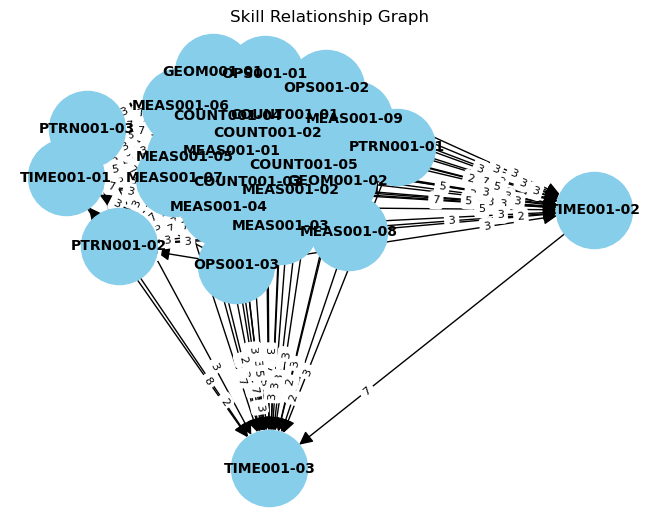


Recommended Global Learning Path (prioritizing dependency):
 -> COUNT001-01
 -> Choice: [COUNT001-02, COUNT001-03, COUNT001-04, COUNT001-05, OPS001-03, PTRN001-03, TIME001-03]
 -> COUNT001-02
 -> Choice: [COUNT001-03, COUNT001-04, COUNT001-05, OPS001-01, OPS001-03]
 -> COUNT001-03
 -> Choice: [COUNT001-04, COUNT001-05, MEAS001-01, MEAS001-02, MEAS001-09, OPS001-01, OPS001-02, OPS001-03, PTRN001-03]
 -> COUNT001-04
 -> Choice: [COUNT001-05, PTRN001-03, TIME001-02]
 -> COUNT001-05
 -> Choice: [MEAS001-09, OPS001-01, OPS001-02, OPS001-03]
 -> MEAS001-09
 -> Choice: [PTRN001-02, PTRN001-03]
 -> PTRN001-02
 -> PTRN001-03
 -> TIME001-01
 -> TIME001-03
 -> GEOM001-01
 -> GEOM001-02
 -> Choice: [MEAS001-01, MEAS001-02, MEAS001-05, PTRN001-01]
 -> MEAS001-01
 -> Choice: [MEAS001-02, MEAS001-03, MEAS001-04, MEAS001-05, MEAS001-08]
 -> MEAS001-02
 -> MEAS001-03
 -> MEAS001-08
 -> Choice: [OPS001-01, OPS001-02, OPS001-03, PTRN001-01]
 -> OPS001-01
 -> Choice: [OPS001-02, OPS001-03]
 -> OPS001-02


In [22]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import os

def visualize_skill_graph(json_data):
    """Visualizes the skill relationship graph."""
    # ... (same visualize_skill_graph function as before) ...
    graph = nx.DiGraph()
    relationship_graph = json_data.get("relationship_graph", {})
    for skill1, relations in relationship_graph.items():
        for skill2, relation_data in relations.items():
            scores = relation_data.get("scores", {})
            dependency = scores.get("dependency", 0)
            similarity = scores.get("similarity", 0)
            reinforcement = scores.get("reinforcement", 0)
            reasoning = relation_data.get("reasoning", "")
            graph.add_edge(skill1, skill2, dependency=dependency, similarity=similarity, reinforcement=reinforcement, reasoning=reasoning)

    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20)
    edge_labels = nx.get_edge_attributes(graph, "dependency")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, label_pos=0.3, font_size=8)
    plt.title("Skill Relationship Graph")
    plt.show()


def generate_global_learning_path(json_data, path_metric='dependency'):
    """
    Generates a global learning path covering all skills using a greedy approach,
    prioritizing skills with higher dependency. Offers choices when there are ties.

    Args:
        json_data (dict): The JSON data.
        path_metric (str): Metric to prioritize ('dependency', 'similarity', 'reinforcement').

    Returns:
        list: A list of skills in the recommended learning order, with choices indicated.
    """
    graph = nx.DiGraph()
    relationship_graph = json_data.get("relationship_graph", {})
    for skill1, relations in relationship_graph.items():
        for skill2, relation_data in relations.items():
            scores = relation_data.get("scores", {})
            dependency = scores.get("dependency", 0)
            similarity = scores.get("similarity", 0)
            reinforcement = scores.get("reinforcement", 0)
            graph.add_edge(skill1, skill2, dependency=dependency, similarity=similarity, reinforcement=reinforcement)

    if path_metric not in ['dependency', 'similarity', 'reinforcement']:
        print(f"Error: Invalid path_metric '{path_metric}'. Choose from 'dependency', 'similarity', 'reinforcement'.")
        return None

    starting_skills = [node for node in graph.nodes() if graph.in_degree(node) == 0]
    if not starting_skills:
        starting_skills = list(graph.nodes()) # If no clear start, begin arbitrarily

    learning_path = []
    learned_skills = set()
    current_skill = starting_skills[0] # Start with the first starting skill found
    learning_path.append(current_skill)
    learned_skills.add(current_skill)


    while len(learned_skills) < len(graph.nodes()):
        possible_next_skills = []
        max_metric_value = -1

        for neighbor in graph.neighbors(current_skill): # Examine neighbors of current skill
            if neighbor not in learned_skills: # Consider only unlearned neighbors
                metric_value = graph[current_skill][neighbor].get(path_metric, 0)
                if metric_value > max_metric_value:
                    max_metric_value = metric_value
                    possible_next_skills = [neighbor] # Start new list with best option
                elif metric_value == max_metric_value:
                    possible_next_skills.append(neighbor) # Add to list of equally good options

        if possible_next_skills:
            if len(possible_next_skills) == 1:
                next_skill = possible_next_skills[0]
                learning_path.append(next_skill)
                learned_skills.add(next_skill)
                current_skill = next_skill
            else:
                learning_path.append(f"Choice: [{', '.join(possible_next_skills)}]") # Indicate choice
                # For greedy path, just pick the first choice to continue the path sequentially
                next_skill = possible_next_skills[0] # Choose first from choices to continue path
                learning_path.append(next_skill)
                learned_skills.add(next_skill)
                current_skill = next_skill

        else: # No more dependent skills from current skill, need to find unlearned skill to continue from
            unlearned_skills = [skill for skill in graph.nodes() if skill not in learned_skills]
            if unlearned_skills:
                current_skill = unlearned_skills[0] # Pick first unlearned skill to continue
                learning_path.append(current_skill)
                learned_skills.add(current_skill)
            else:
                break # All skills learned, path complete


    return learning_path




with open('data/math_relationships.json', 'r') as f:
    data = json.load(f)


visualize_skill_graph(data) # Visualize as before

# Generate and print global learning path
global_path = generate_global_learning_path(data, path_metric='dependency')

if global_path:
    print("\nRecommended Global Learning Path (prioritizing dependency):")
    for item in global_path:
        print(f" -> {item}")
else:
    print("Could not generate global learning path (invalid path metric).")

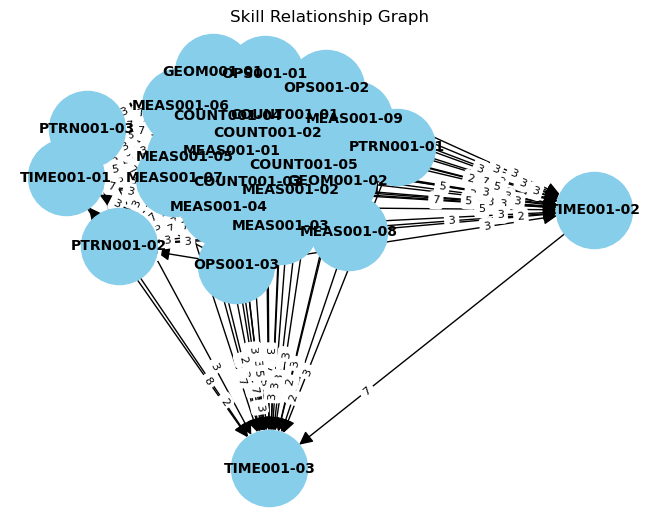


Learning Path Decision Tree Data (JSON-like):
Learning path decision tree saved to: data/learning_path_decision_tree.json


In [30]:
def generate_learning_path_decision_tree(json_data, path_metric='dependency'):
    """
    Generates a decision tree-like data structure for the learning path,
    explicitly representing choices as branches.

    Args:
        json_data (dict): The JSON data.
        path_metric (str): Metric to prioritize ('dependency', 'similarity', 'reinforcement').

    Returns:
        dict: A dictionary representing the decision tree, where each key is a skill
              and the value is a list of possible next steps (skills or choices).
    """
    graph = nx.DiGraph()
    relationship_graph = json_data.get("relationship_graph", {})
    for skill1, relations in relationship_graph.items():
        for skill2, relation_data in relations.items():
            scores = relation_data.get("scores", {})
            dependency = scores.get("dependency", 0)
            similarity = scores.get("similarity", 0)
            reinforcement = scores.get("reinforcement", 0)
            graph.add_edge(skill1, skill2, dependency=dependency, similarity=similarity, reinforcement=reinforcement)

    if path_metric not in ['dependency', 'similarity', 'reinforcement']:
        print(f"Error: Invalid path_metric '{path_metric}'. Choose from 'dependency', 'similarity', 'reinforcement'.")
        return None

    starting_skills = [node for node in graph.nodes() if graph.in_degree(node) == 0]
    if not starting_skills:
        starting_skills = list(graph.nodes())

    decision_tree_data = {}
    queue = starting_skills[:]  # Start with starting skills
    processed_skills = set()

    while queue:
        current_skill = queue.pop(0)
        if current_skill in processed_skills:
            continue
        processed_skills.add(current_skill)

        possible_next_skills = []
        max_metric_value = -1

        for neighbor in graph.neighbors(current_skill):
            metric_value = graph[current_skill][neighbor].get(path_metric, 0)
            if metric_value > max_metric_value:
                max_metric_value = metric_value
                possible_next_skills = [neighbor]
            elif metric_value == max_metric_value:
                possible_next_skills.append(neighbor)

        if possible_next_skills:
            decision_tree_data[current_skill] = possible_next_skills
            queue.extend(possible_next_skills) # Add next skills to queue for further processing
        else:
            decision_tree_data[current_skill] = [] # Leaf node


    return decision_tree_data


# ... (rest of your code, including loading JSON and saving) ...

with open('data/math_Relationships.json', 'r') as f:
    data = json.load(f)


visualize_skill_graph(data) # Visualize as before

# Generate learning path decision tree data
decision_tree_data = generate_learning_path_decision_tree(data, path_metric='dependency')

if decision_tree_data:
    print("\nLearning Path Decision Tree Data (JSON-like):")
    output_filename = 'data/learning_path_decision_tree.json' # Define the output filename
    os.makedirs(os.path.dirname(output_filename), exist_ok=True) # Ensure directory exists

    with open(output_filename, 'w') as outfile:
        json.dump({"learning_path_decision_tree": decision_tree_data}, outfile, indent=2) # Save to file

    print(f"Learning path decision tree saved to: {output_filename}")


else:
    print("Could not generate learning path decision tree data (invalid path metric).")

In [29]:
decision_tree_data

[{'skill': 'COUNT001-01', 'choices': []},
 {'skill': None,
  'choices': ['COUNT001-02',
   'COUNT001-03',
   'COUNT001-04',
   'COUNT001-05',
   'OPS001-03',
   'PTRN001-03',
   'TIME001-03']},
 {'skill': 'COUNT001-02', 'choices': []},
 {'skill': None,
  'choices': ['COUNT001-03',
   'COUNT001-04',
   'COUNT001-05',
   'OPS001-01',
   'OPS001-03']},
 {'skill': 'COUNT001-03', 'choices': []},
 {'skill': None,
  'choices': ['COUNT001-04',
   'COUNT001-05',
   'MEAS001-01',
   'MEAS001-02',
   'MEAS001-09',
   'OPS001-01',
   'OPS001-02',
   'OPS001-03',
   'PTRN001-03']},
 {'skill': 'COUNT001-04', 'choices': []},
 {'skill': None, 'choices': ['COUNT001-05', 'PTRN001-03', 'TIME001-02']},
 {'skill': 'COUNT001-05', 'choices': []},
 {'skill': None,
  'choices': ['MEAS001-09', 'OPS001-01', 'OPS001-02', 'OPS001-03']},
 {'skill': 'MEAS001-09', 'choices': []},
 {'skill': None, 'choices': ['PTRN001-02', 'PTRN001-03']},
 {'skill': 'PTRN001-02', 'choices': []},
 {'skill': 'PTRN001-03', 'choices': []}

In [21]:
import networkx as nx
from pyvis.network import Network
import json
import colorsys

class SkillNetworkVisualizer:
    def __init__(self, relationship_data: dict):
        self.graph = relationship_data['relationship_graph']
        
    def create_force_graph(self, 
                          min_strength: float = 7.0,
                          physics_enabled: bool = True,
                          height: str = "750px",
                          width: str = "100%"):
        """Create interactive force-directed graph"""
        
        # Create network
        net = Network(height=height, width=width, bgcolor="#222222", font_color="white")
        net.force_atlas_2based()
        
        # Configure physics
        net.toggle_physics(physics_enabled)
        
        # Track added nodes and their units
        added_nodes = set()
        unit_colors = {}
        
        # Helper to generate distinct colors
        def get_unit_color(unit_prefix):
            if unit_prefix not in unit_colors:
                hue = len(unit_colors) * 0.1 % 1.0  # Space hues evenly
                rgb = colorsys.hsv_to_rgb(hue, 0.8, 0.9)
                unit_colors[unit_prefix] = '#{:02x}{:02x}{:02x}'.format(
                    int(rgb[0] * 255),
                    int(rgb[1] * 255),
                    int(rgb[2] * 255)
                )
            return unit_colors[unit_prefix]
        
        # Add nodes and edges
        for skill1, relationships in self.graph.items():
            unit1 = skill1[:8]  # Adjust prefix length as needed
            
            # Add first node if not already added
            if skill1 not in added_nodes:
                net.add_node(
                    skill1,
                    label=skill1,
                    title=f"Unit: {unit1}",
                    color=get_unit_color(unit1),
                    size=20
                )
                added_nodes.add(skill1)
            
            # Process relationships
            for skill2, comparison in relationships.items():
                unit2 = skill2[:8]
                
                # Add second node if needed
                if skill2 not in added_nodes:
                    net.add_node(
                        skill2,
                        label=skill2,
                        title=f"Unit: {unit2}",
                        color=get_unit_color(unit2),
                        size=20
                    )
                    added_nodes.add(skill2)
                
                # Add edges for strong relationships
                scores = comparison['scores']
                
                # Dependency edge
                if scores['dependency'] >= min_strength:
                    net.add_edge(
                        skill1, 
                        skill2,
                        value=scores['dependency'],
                        title=f"Dependency: {scores['dependency']:.1f}",
                        color="rgba(255, 255, 255, 0.2)",
                        arrows="to"
                    )
                
                # Reinforcement edge
                if scores['reinforcement'] >= min_strength:
                    net.add_edge(
                        skill1,
                        skill2,
                        value=scores['reinforcement'],
                        title=f"Reinforcement: {scores['reinforcement']:.1f}",
                        color="rgba(76, 175, 80, 0.2)",
                        dashes=True
                    )
        
        # Configure visualization options
        net.set_options("""
        var options = {
            "nodes": {
                "borderWidth": 2,
                "borderWidthSelected": 4,
                "opacity": 0.9,
                "font": {
                    "size": 12,
                    "face": "Tahoma"
                },
                "scaling": {
                    "min": 20,
                    "max": 40
                }
            },
            "edges": {
                "smooth": {
                    "type": "continuous",
                    "forceDirection": "none"
                },
                "width": 1,
                "color": {
                    "inherit": false
                },
                "scaling": {
                    "min": 1,
                    "max": 3
                }
            },
            "physics": {
                "forceAtlas2Based": {
                    "gravitationalConstant": -100,
                    "centralGravity": 0.01,
                    "springLength": 200,
                    "springConstant": 0.08
                },
                "maxVelocity": 50,
                "minVelocity": 0.1,
                "solver": "forceAtlas2Based",
                "timestep": 0.35
            },
            "interaction": {
                "navigationButtons": true,
                "keyboard": true,
                "hover": true
            }
        }
        """)
        
        return net
    
    def save_graph(self, output_file: str = "skill_network.html", **kwargs):
        """Create and save the network visualization"""
        net = self.create_force_graph(**kwargs)
        net.save_graph(output_file)
        print(f"Graph saved to {output_file}")
        return net

# Example usage:
with open('data/math_relationships.json', 'r') as f:
    relationship_data = json.load(f)
#
visualizer = SkillNetworkVisualizer(relationship_data)
net = visualizer.save_graph(
    min_strength=7.0,
    physics_enabled=True,
    height="750px"
)

Graph saved to skill_network.html


In [22]:
import networkx as nx
from pyvis.network import Network
import json
import colorsys

class SkillNetworkVisualizer:
    def __init__(self, relationship_data: dict):
        self.graph = relationship_data['relationship_graph']
        
    def create_force_graph(self, 
                          min_strength: float = 7.0,
                          physics_enabled: bool = True,
                          height: str = "750px",
                          width: str = "100%"):
        """Create interactive hierarchical layout with foundational skills on the left"""
        
        # Create network
        net = Network(height=height, width=width, bgcolor="#222222", font_color="white")
        
        # Track added nodes and their units
        added_nodes = set()
        unit_colors = {}
        max_level = 0  # To normalize positions
        
        # First pass to find max_level
        for skill in self.graph.keys():
            _, level = self._parse_skill_id(skill)
            if level > max_level:
                max_level = level

        # Helper to generate distinct colors
        def get_unit_color(unit_prefix):
            if unit_prefix not in unit_colors:
                hue = len(unit_colors) * 0.1 % 1.0  # Space hues evenly
                rgb = colorsys.hsv_to_rgb(hue, 0.8, 0.9)
                unit_colors[unit_prefix] = '#{:02x}{:02x}{:02x}'.format(
                    int(rgb[0] * 255),
                    int(rgb[1] * 255),
                    int(rgb[2] * 255)
                )
            return unit_colors[unit_prefix]

        # Add nodes with hierarchical attributes
        for skill in self.graph.keys():
            unit, level = self._parse_skill_id(skill)
            net.add_node(
                skill,
                label=skill,
                title=f"Unit: {unit}\nLevel: {level}",
                color=get_unit_color(unit),
                size=20,
                level=level  # Critical for hierarchical layout
            )
            added_nodes.add(skill)

        # Add edges
        for skill1, relationships in self.graph.items():
            for skill2, comparison in relationships.items():
                # Ensure both nodes exist
                if skill2 not in added_nodes:
                    unit, level = self._parse_skill_id(skill2)
                    net.add_node(
                        skill2,
                        label=skill2,
                        title=f"Unit: {unit}\nLevel: {level}",
                        color=get_unit_color(unit),
                        size=20,
                        level=level
                    )
                    added_nodes.add(skill2)
                
                scores = comparison['scores']
                
                # Dependency edge
                if scores['dependency'] >= min_strength:
                    net.add_edge(
                        skill1, 
                        skill2,
                        value=scores['dependency'],
                        title=f"Dependency: {scores['dependency']:.1f}",
                        color="rgba(255, 255, 255, 0.2)",
                        arrows="to"
                    )
                
                # Reinforcement edge
                if scores['reinforcement'] >= min_strength:
                    net.add_edge(
                        skill1,
                        skill2,
                        value=scores['reinforcement'],
                        title=f"Reinforcement: {scores['reinforcement']:.1f}",
                        color="rgba(76, 175, 80, 0.2)",
                        dashes=True
                    )

        # Configure hierarchical layout options
        net.set_options("""
        {
            "layout": {
                "hierarchical": {
                    "enabled": true,
                    "direction": "LR",
                    "sortMethod": "directed",
                    "nodeSpacing": 150,
                    "treeSpacing": 200
                }
            },
            "physics": {
                "hierarchicalRepulsion": {
                    "centralGravity": 0.0,
                    "springLength": 200,
                    "springConstant": 0.01,
                    "nodeDistance": 120,
                    "damping": 0.09
                },
                "solver": "hierarchicalRepulsion"
            },
            "nodes": {
                "borderWidth": 2,
                "borderWidthSelected": 4,
                "opacity": 0.9,
                "font": {"size": 12, "face": "Tahoma"}
            },
            "edges": {
                "smooth": {"type": "continuous"},
                "width": 1,
                "color": {"inherit": false}
            },
            "interaction": {
                "navigationButtons": true,
                "keyboard": true,
                "hover": true
            }
        }
        """)
        
        return net

    def _parse_skill_id(self, skill_id: str):
        """Extract unit and level from skill ID (format: UNIT-LEVEL)"""
        parts = skill_id.split('-')
        if len(parts) != 2:
            return skill_id, 0
        try:
            return parts[0], int(parts[1])
        except ValueError:
            return parts[0], 0

    def save_graph(self, output_file: str = "skill_network deepseek.html", **kwargs):
        """Create and save the network visualization"""
        net = self.create_force_graph(**kwargs)
        net.save_graph(output_file)
        print(f"Graph saved to {output_file}")
        return net
    

# Example usage:
with open('data/math_relationships.json', 'r') as f:
    relationship_data = json.load(f)
#
visualizer = SkillNetworkVisualizer(relationship_data)
net = visualizer.save_graph(min_strength=7.0,
    physics_enabled=True,
    height="750px")

Graph saved to skill_network deepseek.html


C:\Users\xbox3\AppData\Local\Temp\ipykernel_13208\3905990217.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


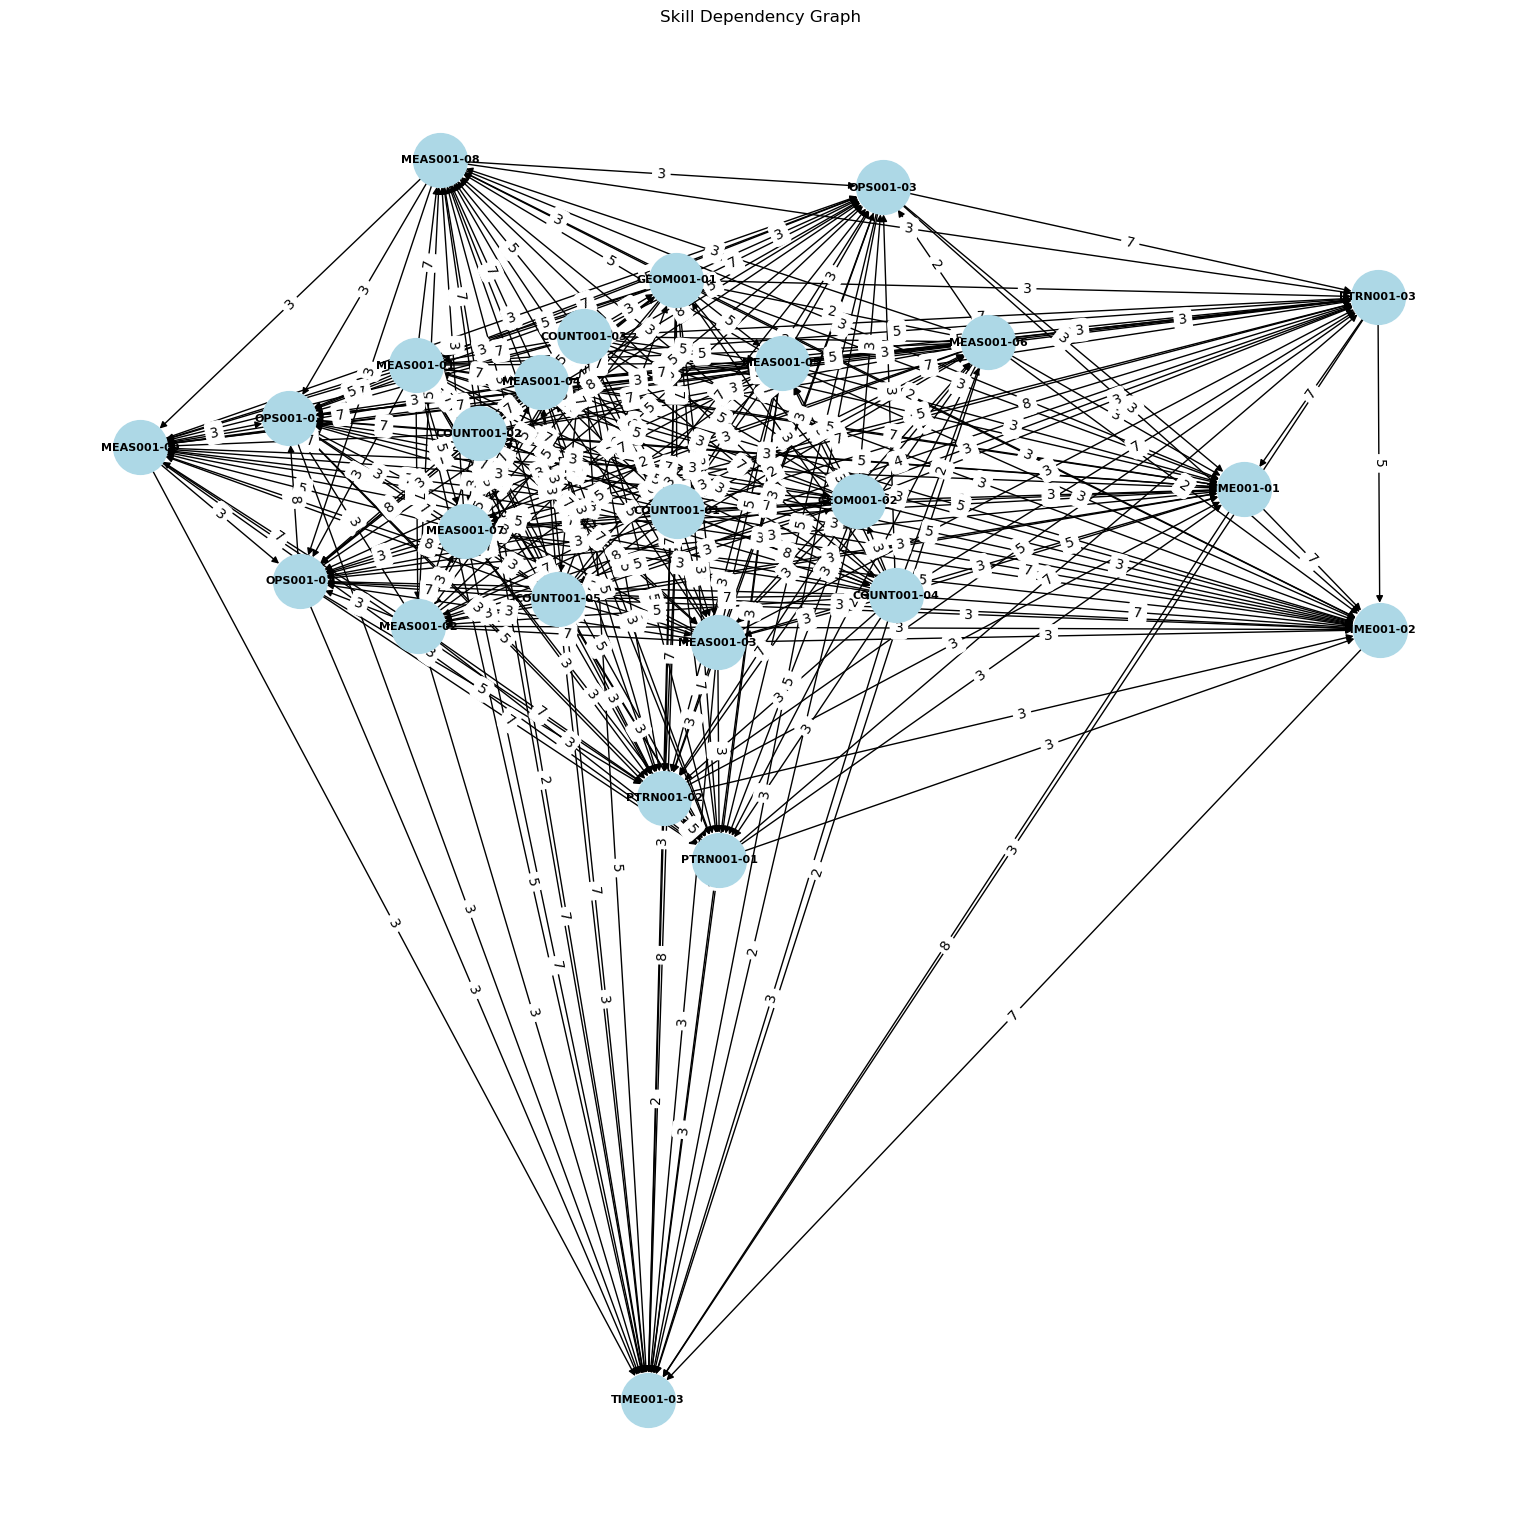

Skill with the highest number of dependencies: COUNT001-01
Skill most depended upon: TIME001-03


In [34]:
import json
import networkx as nx
import matplotlib.pyplot as plt

# Load the JSON data
with open('data/math_relationships.json', 'r') as file:
    data = json.load(file)

# Create a directed graph
G = nx.DiGraph()

# Function to add edges based on dependency scores
def add_edges(graph, data):
    for skill_from, connections in data['relationship_graph'].items():
        for skill_to, details in connections.items():
            # Use dependency score for edge weight
            dependency_score = details['scores']['dependency']
            graph.add_edge(skill_from, skill_to, weight=dependency_score)

# Add edges to the graph
add_edges(G, data)

# Calculate layout for a clearer visualization
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw the graph
plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=1500, font_size=8, font_weight='bold', arrows=True)

# Draw edge weights (dependency scores)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title("Skill Dependency Graph")
plt.axis('off')
plt.tight_layout()
plt.show()

# Optionally, you can analyze the graph further
# For example, find the most dependent skill:
most_dependent_skill = max(G, key=G.out_degree)
print(f"Skill with the highest number of dependencies: {most_dependent_skill}")

# Or find the skill most depended upon:
most_depended_on = max(G, key=G.in_degree)
print(f"Skill most depended upon: {most_depended_on}")

In [26]:
visualizer

In [ ]:
net

In [10]:
import networkx as nx
from pyvis.network import Network
import json
import colorsys

class LearningPathVisualizer:
    def __init__(self, relationship_data: dict):
        self.graph = relationship_data['relationship_graph']
        
    def visualize_learning_path(self, 
                              path: list,
                              output_file: str = "learning_path.html",
                              height: str = "750px",
                              width: str = "100%"):
        """Create visualization with highlighted learning path"""
        
        # Create network
        net = Network(height=height, width=width, bgcolor="#222222", font_color="white")
        net.force_atlas_2based()
        
        # Track nodes and their units
        added_nodes = set()
        unit_colors = {
            'COUNT': '#ff4444',  # Red
            'TIME': '#00cccc',   # Turquoise
            'PTRN': '#44ff44',   # Green
            'MEAS': '#cccc00',   # Yellow
            'GEOM': '#ff8c00',   # Orange
            'OPS': '#44ff44'     # Green
        }
        
        # Add all nodes first
        for skill1, relationships in self.graph.items():
            unit = skill1[:4]  # Get unit prefix
            
            # Determine if node is in the path
            in_path = skill1 in path
            size = 30 if in_path else 20
            border_width = 3 if in_path else 1
            
            # Add node
            if skill1 not in added_nodes:
                net.add_node(
                    skill1,
                    label=skill1,
                    title=f"Unit: {unit}",
                    color=unit_colors.get(unit, '#ffffff'),
                    size=size,
                    borderWidth=border_width
                )
                added_nodes.add(skill1)
            
            # Add related nodes
            for skill2 in relationships:
                if skill2 not in added_nodes:
                    unit2 = skill2[:4]
                    in_path2 = skill2 in path
                    size2 = 30 if in_path2 else 20
                    border_width2 = 3 if in_path2 else 1
                    
                    net.add_node(
                        skill2,
                        label=skill2,
                        title=f"Unit: {unit2}",
                        color=unit_colors.get(unit2, '#ffffff'),
                        size=size2,
                        borderWidth=border_width2
                    )
                    added_nodes.add(skill2)
        
        # Add edges
        for i in range(len(path) - 1):
            # Add path edges with distinct styling
            net.add_edge(
                path[i],
                path[i + 1],
                color='#ffffff',
                width=3,
                arrows='to',
                physics=False  # Make path edges fixed
            )
        
        # Add other relationships as background
        for skill1, relationships in self.graph.items():
            for skill2, comparison in relationships.items():
                # Skip if this is a path edge
                if skill1 in path and skill2 in path and abs(path.index(skill1) - path.index(skill2)) == 1:
                    continue
                    
                scores = comparison['scores']
                
                # Add dependency edges
                if scores['dependency'] >= 7.0:
                    net.add_edge(
                        skill1,
                        skill2,
                        color='rgba(255, 255, 255, 0.1)',
                        width=1,
                        arrows='to'
                    )
                
                # Add reinforcement edges
                if scores['reinforcement'] >= 7.0:
                    net.add_edge(
                        skill1,
                        skill2,
                        color='rgba(76, 175, 80, 0.1)',
                        width=1,
                        dashes=True
                    )
        
        # Configure visualization options
        net.set_options("""
        var options = {
            "nodes": {
                "opacity": 0.9,
                "font": {
                    "size": 14,
                    "face": "Tahoma"
                }
            },
            "edges": {
                "smooth": {
                    "type": "continuous",
                    "forceDirection": "none"
                },
                "color": {
                    "inherit": false
                }
            },
            "physics": {
                "forceAtlas2Based": {
                    "gravitationalConstant": -100,
                    "centralGravity": 0.01,
                    "springLength": 200,
                    "springConstant": 0.08
                },
                "maxVelocity": 50,
                "minVelocity": 0.1,
                "solver": "forceAtlas2Based"
            },
            "interaction": {
                "navigationButtons": true,
                "keyboard": true,
                "hover": true
            }
        }
        """)
        
        net.save_graph(output_file)
        print(f"Graph saved to {output_file}")
        return net

# Example usage:
path = [
     "COUNT001-01",
     "COUNT001-02",
     "COUNT001-03",
     "COUNT001-04",
    "COUNT001-05",
     "MEAS001-09",
     "PTRN001-02",
     "PTRN001-03",
     "TIME001-01",
     "TIME001-03"]
#
visualizer = LearningPathVisualizer(relationship_data)
net = visualizer.visualize_learning_path(path)

Graph saved to learning_path.html


In [ ]:
class NormalizedHierarchicalVisualizer:
    def __init__(self, relationship_data: dict):
        self.raw_graph = relationship_data['relationship_graph']
        self.stats = self._calculate_statistics()
        
    def _calculate_statistics(self):
        """Calculate mean and standard deviation for each score type"""
        scores = {'dependency': [], 'similarity': [], 'reinforcement': []}
        for rels in self.raw_graph.values():
            for comparison in rels.values():
                for score_type, score in comparison['scores'].items():
                    scores[score_type].append(score)
        
        stats = {}
        for score_type, values in scores.items():
            mean = sum(values) / len(values)
            variance = sum((x - mean) ** 2 for x in values) / len(values)
            std_dev = variance ** 0.5
            stats[score_type] = {'mean': mean, 'std_dev': std_dev}
            print(f"{score_type}: mean={mean:.2f}, std_dev={std_dev:.2f}")
        return stats
    
    def normalize_score(self, score_type: str, raw_score: float) -> float:
        """Convert score to z-score then scale to 0-10"""
        stats = self.stats[score_type]
        z_score = (raw_score - stats['mean']) / stats['std_dev']
        normalized = 5 + (z_score * 1.5)
        return max(0, min(10, normalized))

    def get_direct_prerequisites(self, skill_id: str, min_dependency: float = 5.0):
        direct_prereqs = []
        for other_id, relationships in self.raw_graph.items():
            if skill_id in relationships:
                raw_dep = relationships[skill_id]['scores']['dependency']
                norm_dep = self.normalize_score('dependency', raw_dep)
                if norm_dep >= min_dependency:
                    direct_prereqs.append((other_id, norm_dep))
                    
        if len(direct_prereqs) > 2:
            direct_prereqs.sort(key=lambda x: x[1], reverse=True)
            direct_prereqs = direct_prereqs[:3]
        return direct_prereqs

    def visualize_normalized(self, output_file: str = "normalized_hierarchy.html"):
        net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
        
        unit_colors = {
            'COUNT': '#ff4444',
            'TIME': '#00cccc',
            'PTRN': '#44ff44',
            'MEAS': '#cccc00',
            'GEOM': '#ff8c00',
            'OPS': '#44ff44'
        }
        
        # Add nodes
        for skill_id in self.raw_graph:
            unit = skill_id[:4]
            net.add_node(
                skill_id,
                label=skill_id,
                color=unit_colors.get(unit, '#ffffff'),
                size=20
            )
        
        # Add edges with normalized weights
        added_edges = set()
        for skill1, relationships in self.raw_graph.items():
            for skill2, comparison in relationships.items():
                edge_key = f"{skill1}_{skill2}"
                if edge_key in added_edges:
                    continue
                    
                norm_dep = self.normalize_score('dependency', comparison['scores']['dependency'])
                norm_reinf = self.normalize_score('reinforcement', comparison['scores']['reinforcement'])
                
                if norm_dep > 5:  # Above mean
                    net.add_edge(
                        skill1,
                        skill2,
                        width=max(1, min(5, (norm_dep - 5))),
                        color={'color': '#ffffff', 'opacity': min(0.8, norm_dep/10)},
                        arrows={'to': {'enabled': True}},
                        smooth={'type': 'curvedCW', 'roundness': 0.2}
                    )
                    added_edges.add(edge_key)
                
                if norm_reinf > 6:  # Above mean + 0.67 std
                    net.add_edge(
                        skill1,
                        skill2,
                        width=1,
                        color={'color': '#44ff44', 'opacity': 0.3},
                        dashes=True,
                        smooth={'type': 'curvedCW', 'roundness': 0.2}
                    )
        
        net.set_options("""
        var options = {
            "physics": {
                "barnesHut": {
                    "gravitationalConstant": -3000,
                    "centralGravity": 0.1,
                    "springLength": 150,
                    "springConstant": 0.02,
                    "damping": 0.09,
                    "avoidOverlap": 0.2
                },
                "minVelocity": 0.5
            }
        }
        """)
        
        net.save_graph(output_file)
        return net

# Usage:
# visualizer = NormalizedHierarchicalVisualizer(relationship_data)
# net = visualizer.visualize_normalized()

Graph saved to streamlined_hierarchy.html


In [15]:
from pyvis.network import Network
import json

class ForceDirectedSkillNetwork:
    def __init__(self, relationship_data: dict):
        self.graph = relationship_data['relationship_graph']
        
    def create_network(self,
                      min_dependency: float = 7.5,
                      min_reinforcement: float = 7.0,
                      output_file: str = "skill_network.html"):
        """Create force-directed network visualization"""
        
        # Initialize network with dark theme
        net = Network(
            height="750px",
            width="100%",
            bgcolor="#222222",
            font_color="white"
        )
        
        # Track added nodes
        added_nodes = set()
        
        # Define unit colors
        unit_colors = {
            'COUNT': '#ff4444',  # Red
            'TIME': '#00cccc',   # Turquoise
            'PTRN': '#44ff44',   # Green
            'MEAS': '#cccc00',   # Yellow
            'GEOM': '#ff8c00',   # Orange
            'OPS': '#44ff44'     # Green (same as PTRN)
        }
        
        # Add nodes
        for skill_id in self.graph:
            if skill_id not in added_nodes:
                unit = skill_id[:4]
                net.add_node(
                    skill_id,
                    label=skill_id,
                    color=unit_colors.get(unit, '#ffffff'),
                    size=20,
                    title=skill_id  # Hover text
                )
                added_nodes.add(skill_id)
                
        # Add edges
        added_edges = set()
        for skill1, relationships in self.graph.items():
            for skill2, comparison in relationships.items():
                edge_key = f"{skill1}_{skill2}"
                if edge_key in added_edges:
                    continue
                    
                scores = comparison['scores']
                
                # Add dependency edges
                if scores['dependency'] >= min_dependency:
                    net.add_edge(
                        skill1,
                        skill2,
                        color={'color': '#ffffff', 'opacity': 0.3},
                        width=1,
                        arrows={'to': {'enabled': True}},
                        physics=True
                    )
                    added_edges.add(edge_key)
                
                # Add reinforcement edges
                if scores['reinforcement'] >= min_reinforcement:
                    rev_edge_key = f"{skill2}_{skill1}"
                    if rev_edge_key not in added_edges:
                        net.add_edge(
                            skill1,
                            skill2,
                            color={'color': '#44ff44', 'opacity': 0.2},
                            width=1,
                            dashes=True,
                            physics=True
                        )
                        added_edges.add(edge_key)
        
        # Configure physics and interaction options
        net.set_options("""
        var options = {
            "nodes": {
                "borderWidth": 2,
                "borderWidthSelected": 3,
                "opacity": 0.9,
                "font": {
                    "size": 14,
                    "face": "Tahoma"
                },
                "scaling": {
                    "min": 20,
                    "max": 20
                }
            },
            "edges": {
                "color": {
                    "inherit": false
                },
                "smooth": {
                    "type": "continuous",
                    "roundness": 0.5
                },
                "width": 1
            },
            "physics": {
                "barnesHut": {
                    "gravitationalConstant": -4000,
                    "centralGravity": 0.3,
                    "springLength": 120,
                    "springConstant": 0.04,
                    "damping": 0.09,
                    "avoidOverlap": 0.1
                },
                "minVelocity": 0.75,
                "solver": "barnesHut",
                "stabilization": {
                    "enabled": true,
                    "iterations": 1000,
                    "updateInterval": 25
                }
            },
            "interaction": {
                "hover": true,
                "navigationButtons": true,
                "keyboard": true
            }
        }
        """)
        
        # Save network
        net.save_graph(output_file)
        print(f"Network saved to {output_file}")
        return net

    def create_focused_network(self, 
                             center_skill: str,
                             depth: int = 2,
                             output_file: str = "focused_network.html"):
        """Create network focused on a specific skill and its neighborhood"""
        
        # Get neighborhood nodes
        neighborhood = {center_skill}
        current_depth = set([center_skill])
        
        for _ in range(depth):
            next_depth = set()
            for skill in current_depth:
                # Add connected skills from relationships
                if skill in self.graph:
                    next_depth.update(self.graph[skill].keys())
                # Add skills that have relationships to this skill
                for other_skill, relationships in self.graph.items():
                    if skill in relationships:
                        next_depth.add(other_skill)
            neighborhood.update(next_depth)
            current_depth = next_depth
        
        # Create subgraph with neighborhood
        subgraph = {
            'relationship_graph': {
                skill: rels 
                for skill, rels in self.graph.items()
                if skill in neighborhood
            }
        }
        
        # Create network with subgraph
        subnet = ForceDirectedSkillNetwork(subgraph)
        return subnet.create_network(output_file=output_file)

# Example usage:
# # Create full network
network = ForceDirectedSkillNetwork(relationship_data)
net = network.create_network(
     min_dependency=7.5,
     min_reinforcement=7.0
)
#
# # Create focused network around specific skill
 focused_net = network.create_focused_network(
    center_skill="COUNT001-01",
     depth=2
)

Network saved to skill_network.html
Network saved to focused_network.html


In [7]:
from anthropic import Anthropic
import pandas as pd
from typing import List, Dict
import time
from pathlib import Path
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Get API key from environment
ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_API_KEY')
if not ANTHROPIC_API_KEY:
    raise ValueError("ANTHROPIC_API_KEY not found in environment variables")

client = Anthropic(api_key=ANTHROPIC_API_KEY)

def expand_existing_skill(client: Anthropic, subject: str, grade: str, unit_id: str, unit_title: str, 
                         skill_id: str, skill_name: str, existing_subskills: list) -> list:
    """
    Expand an existing skill with additional subskills, returning rows for CSV format
    """
    print(f"\n📝 Generating new subskills for {skill_id}: {skill_name}")
    print(f"  • Found {len(existing_subskills)} existing subskills")
    print("  • Preparing prompt for Claude...")
    
    prompt = f"""Create 10-15 NEW specific, measurable learning objectives (subskills) for this kindergarten subject.
DO NOT duplicate any existing subskills.

Skill: {skill_name}

Existing subskills (DO NOT DUPLICATE THESE):
{chr(10).join('- ' + s for s in existing_subskills)}

Each new subskill should:
- Be distinct from existing subskills
- Be achievable in 1-2 learning sessions
- Build progressively in complexity
- Focus on observable outcomes
- Include clear success criteria

Format each NEW subskill exactly as follows:

SUBSKILL_ID: [skill_id-E] (continuing after existing A-D with E, F, etc.)
DESCRIPTION: [Clear, specific learning objective]
DIFFICULTY: [start 1-10]-[end 1-10]-[target 1-10]
---"""

    print("  • Sending request to Claude API...")
    response = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1000,
        temperature=0.7,
        messages=[{"role": "user", "content": prompt}]
    )
    print("  • Received response from Claude")
    
    # Parse response into CSV rows
    rows = []
    current_subskill = {}
    
    print("  • Parsing response into CSV format...")
    for line in response.content[0].text.strip().split('\n'):
        line = line.strip()
        if not line or line == '---':
            if current_subskill and len(current_subskill) == 3:  # Only if we have all required fields
                # Parse difficulty string
                diff_parts = current_subskill['DIFFICULTY'].split('-')
                if len(diff_parts) == 3:
                    rows.append({
                        'Subject': subject,
                        'Grade': grade,
                        'UnitID': unit_id,
                        'UnitTitle': unit_title,
                        'SkillID': skill_id,
                        'SkillDescription': skill_name,
                        'SubskillID': current_subskill['SUBSKILL_ID'],
                        'SubskillDescription': current_subskill['DESCRIPTION'],
                        'DifficultyStart': diff_parts[0],
                        'DifficultyEnd': diff_parts[1],
                        'TargetDifficulty': diff_parts[2]
                    })
            current_subskill = {}
            continue
            
        if ': ' in line:
            key, value = line.split(': ', 1)
            current_subskill[key] = value.strip()
    
    # Process final subskill if exists
    if current_subskill and len(current_subskill) == 3:
        diff_parts = current_subskill['DIFFICULTY'].split('-')
        if len(diff_parts) == 3:
            rows.append({
                'Subject': subject,
                'Grade': grade,
                'UnitID': unit_id,
                'UnitTitle': unit_title,
                'SkillID': skill_id,
                'SkillDescription': skill_name,
                'SubskillID': current_subskill['SUBSKILL_ID'],
                'SubskillDescription': current_subskill['DESCRIPTION'],
                'DifficultyStart': diff_parts[0],
                'DifficultyEnd': diff_parts[1],
                'TargetDifficulty': diff_parts[2]
            })
    
    print(f"  • Successfully generated {len(rows)} new subskills")
    return rows

def expand_all_skills(client: Anthropic, input_csv: str, output_csv: str):
    """
    Expand all skills from input CSV and write directly to output CSV
    """
    print(f"\n🔄 Reading input CSV: {input_csv}")
    # Read existing data
    df = pd.read_csv(input_csv)
    print(f"  • Found {len(df)} total rows")
    
    # Create output dataframe with same columns
    output_rows = []
    
    # Get unique skills
    skills_df = df.drop_duplicates(['SkillID', 'SkillDescription'])
    print(f"  • Identified {len(skills_df)} unique skills to process")
    
    for idx, skill in skills_df.iterrows():
        skill_id = skill['SkillID']
        print(f"\n✨ Processing skill {idx + 1}/{len(skills_df)}")
        print(f"  • Current skill: {skill_id}: {skill['SkillDescription']}")
        
        # Get existing subskills for this skill
        skill_df = df[df['SkillID'] == skill_id]
        existing_subskills = skill_df['SubskillDescription'].tolist()
        
        # Expand skill
        new_rows = expand_existing_skill(
            client=client,
            subject=skill['Subject'],
            grade=skill['Grade'],
            unit_id=skill['UnitID'],
            unit_title=skill['UnitTitle'],
            skill_id=skill_id,
            skill_name=skill['SkillDescription'],
            existing_subskills=existing_subskills
        )
        
        output_rows.extend(new_rows)
        
        # Add delay between API calls
        print("  • Waiting 2 seconds before next API call...")
        time.sleep(2)
    
    print("\n📊 Combining results...")
    # Combine existing and new rows
    all_rows = pd.concat([df, pd.DataFrame(output_rows)])
    
    # Save to CSV
    print(f"💾 Saving results to {output_csv}")
    all_rows.to_csv(output_csv, index=False)
    print(f"✅ Complete! Final statistics:")
    print(f"  • Original rows: {len(df)}")
    print(f"  • New rows added: {len(output_rows)}")
    print(f"  • Total rows in output: {len(all_rows)}")

expand_all_skills(
        client=client,
        input_csv="data/science-syllabus.csv",
        output_csv="data/sciencesyllabus_expanded.csv"
    )


🔄 Reading input CSV: data/science-syllabus.csv
  • Found 39 total rows
  • Identified 11 unique skills to process

✨ Processing skill 1/11
  • Current skill: SCI001-01: Forces and Motion

📝 Generating new subskills for SCI001-01: Forces and Motion
  • Found 4 existing subskills
  • Preparing prompt for Claude...
  • Sending request to Claude API...
  • Received response from Claude
  • Parsing response into CSV format...
  • Successfully generated 12 new subskills
  • Waiting 2 seconds before next API call...

✨ Processing skill 5/11
  • Current skill: SCI001-02: Matter and Its Properties

📝 Generating new subskills for SCI001-02: Matter and Its Properties
  • Found 4 existing subskills
  • Preparing prompt for Claude...
  • Sending request to Claude API...
  • Received response from Claude
  • Parsing response into CSV format...
  • Successfully generated 12 new subskills
  • Waiting 2 seconds before next API call...

✨ Processing skill 9/11
  • Current skill: SCI001-03: Energy

📝 Ge

In [8]:
expand_all_skills(
        client=client,
        input_csv="data/social-studies-syllabus.csv",
        output_csv="data/ssocial-studies-syllabus_expanded.csv"
    )


🔄 Reading input CSV: data/social-studies-syllabus.csv
  • Found 38 total rows
  • Identified 11 unique skills to process

✨ Processing skill 1/11
  • Current skill: SS001-01: Rules and Responsibilities

📝 Generating new subskills for SS001-01: Rules and Responsibilities
  • Found 4 existing subskills
  • Preparing prompt for Claude...
  • Sending request to Claude API...
  • Received response from Claude
  • Parsing response into CSV format...
  • Successfully generated 12 new subskills
  • Waiting 2 seconds before next API call...

✨ Processing skill 5/11
  • Current skill: SS001-02: Citizenship

📝 Generating new subskills for SS001-02: Citizenship
  • Found 4 existing subskills
  • Preparing prompt for Claude...
  • Sending request to Claude API...
  • Received response from Claude
  • Parsing response into CSV format...
  • Successfully generated 12 new subskills
  • Waiting 2 seconds before next API call...

✨ Processing skill 9/11
  • Current skill: SS001-03: Government

📝 Genera

In [9]:
expand_all_skills(
        client=client,
        input_csv="data/language-arts-syllabus.csv",
        output_csv="data/language-arts-syllabus_expanded.csv"
    )


🔄 Reading input CSV: data/language-arts-syllabus.csv
  • Found 20 total rows
  • Identified 7 unique skills to process

✨ Processing skill 1/7
  • Current skill: LA001-01: Print Concepts

📝 Generating new subskills for LA001-01: Print Concepts
  • Found 3 existing subskills
  • Preparing prompt for Claude...
  • Sending request to Claude API...
  • Received response from Claude
  • Parsing response into CSV format...
  • Successfully generated 11 new subskills
  • Waiting 2 seconds before next API call...

✨ Processing skill 4/7
  • Current skill: LA001-02: Phonological Awareness

📝 Generating new subskills for LA001-02: Phonological Awareness
  • Found 3 existing subskills
  • Preparing prompt for Claude...
  • Sending request to Claude API...
  • Received response from Claude
  • Parsing response into CSV format...
  • Successfully generated 11 new subskills
  • Waiting 2 seconds before next API call...

✨ Processing skill 7/7
  • Current skill: LA001-03: Phonics and Word Recognitio

In [10]:
expand_all_skills(
        client=client,
        input_csv="data/kindergartenmathsyllabus v2.csv",
        output_csv="data/kindergartenmathsyllabus v2_expanded.csv"
    )


🔄 Reading input CSV: data/kindergartenmathsyllabus v2.csv
  • Found 56 total rows
  • Identified 12 unique skills to process

✨ Processing skill 1/12
  • Current skill: COUNT001-01: Know number names and the count sequence

📝 Generating new subskills for COUNT001-01: Know number names and the count sequence
  • Found 9 existing subskills
  • Preparing prompt for Claude...
  • Sending request to Claude API...
  • Received response from Claude
  • Parsing response into CSV format...
  • Successfully generated 12 new subskills
  • Waiting 2 seconds before next API call...

✨ Processing skill 10/12
  • Current skill: COUNT001-02: Count to tell the number of objects

📝 Generating new subskills for COUNT001-02: Count to tell the number of objects
  • Found 5 existing subskills
  • Preparing prompt for Claude...
  • Sending request to Claude API...
  • Received response from Claude
  • Parsing response into CSV format...
  • Successfully generated 11 new subskills
  • Waiting 2 seconds befor

In [11]:
expand_all_skills(
        client=client,
        input_csv="data/Arts-syllabus.csv",
        output_csv="data/Arts-syllabus_expanded.csv"
    )


🔄 Reading input CSV: data/Arts-syllabus.csv
  • Found 27 total rows
  • Identified 9 unique skills to process

✨ Processing skill 1/9
  • Current skill: ART001-01: Creating

📝 Generating new subskills for ART001-01: Creating
  • Found 3 existing subskills
  • Preparing prompt for Claude...
  • Sending request to Claude API...
  • Received response from Claude
  • Parsing response into CSV format...
  • Successfully generated 12 new subskills
  • Waiting 2 seconds before next API call...

✨ Processing skill 4/9
  • Current skill: ART001-02: Presenting

📝 Generating new subskills for ART001-02: Presenting
  • Found 3 existing subskills
  • Preparing prompt for Claude...
  • Sending request to Claude API...
  • Received response from Claude
  • Parsing response into CSV format...
  • Successfully generated 12 new subskills
  • Waiting 2 seconds before next API call...

✨ Processing skill 7/9
  • Current skill: ART001-03: Responding

📝 Generating new subskills for ART001-03: Responding
  